# Time delay-cosmography with uncertain PSF

This notebook requires standard python libraries and the publicly available packages on github:

- lenstronomy (https://github.com/lenstronomy/lenstronomy)


For further information, please get in touch with the lenstronomy developers.

In [1]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

# lenstronomy imports
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

## simulation choices

/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_81754/1537311550.py:19: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(kernel))


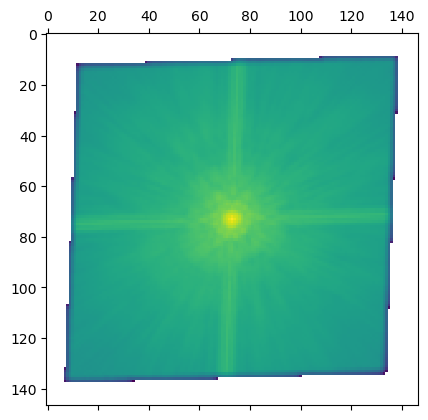

/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_81754/1537311550.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(kernel_blurred))


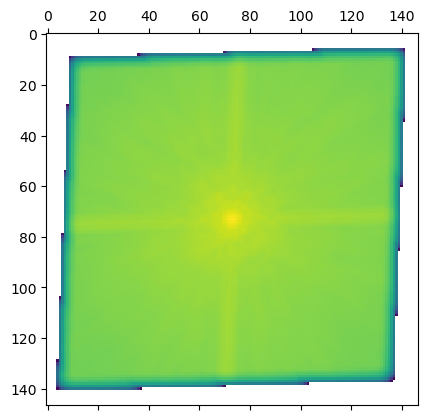

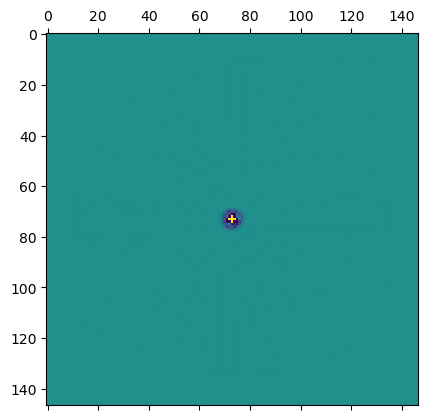

In [2]:

# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.5
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)


# import PSF file
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, 'Data/PSF_TinyTim/psf_example.fits')
kernel = pyfits.getdata(psf_filename)

# blurr the PSF, this will be our starting point estimate
import scipy.ndimage as ndimage
kernel_blurred = ndimage.filters.gaussian_filter(kernel, 0.5, mode='nearest', truncate=5)

plt.matshow(np.log10(kernel))
plt.show()

plt.matshow(np.log10(kernel_blurred))
plt.show()

plt.matshow(kernel - kernel_blurred, vmin=-0.001, vmax=0.001)
plt.show()

    
# data specifics
sigma_bkg = .05  #  background noise per pixel (Gaussian)
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91

# initial input simulation

# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
data_class = ImageData(**kwargs_data)
# generate the psf variables
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf_true = {'psf_type': psf_type, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut}

kernel_cut_blurred = kernel_util.cut_psf(kernel_blurred, kernel_size)
kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut_blurred}
psf_class_true = PSF(**kwargs_psf_true)
psf_class = PSF(**kwargs_psf)


/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_81754/2468647952.py:70: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad(color='k', alpha=1.)
/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_81754/2468647952.py:71: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_under('k')
/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_81754/2468647952.py:78: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10

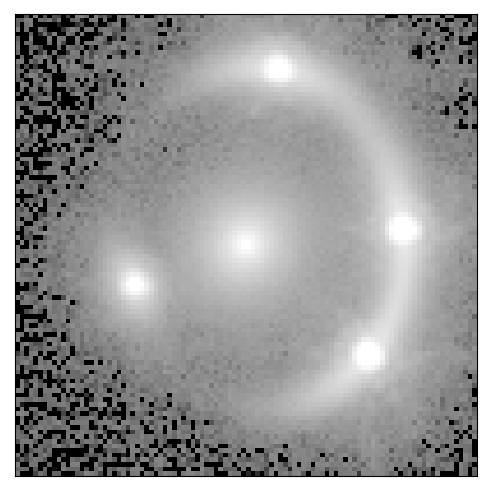

In [3]:
# lensing quantities
gamma1, gamma2 = param_util.shear_polar2cartesian(phi=-np.pi/2, gamma=0.05)
kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}  # shear values
kwargs_pemd = {'theta_E': 1.66, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}  # parameters of the deflector lens model

# the lens model is a supperposition of an elliptical lens model with external shear
lens_model_list = ['EPL', 'SHEAR']
kwargs_lens = [kwargs_pemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=z_lens, z_source=z_source, cosmo=cosmo)

# choice of source type
source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'

source_x = 0.2
source_y = 0.1


# Sersic parameters in the initial simulation
phi_G, q = 0.5, 0.8
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
#kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)


# lens light model
phi_G, q = 0.9, 0.9
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(source_x, source_y, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': np.abs(mag)*1000}]  # quasar point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False,
                  'point_source_supersampling_factor': 1}

imageModel = ImageModel(data_class, psf_class_true, lens_model_class, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)

# generate image
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=sigma_bkg)
image_sim = image_sim + bkg + poisson
data_class.update_data(image_sim)
kwargs_data['image_data'] = image_sim


kwargs_model = {'lens_model_list': lens_model_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

# display the initial simulated image
cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 2

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

## time delays
time delays are defined in **lenstronomy** as the difference in light travel path relative to a straight line. Negative values correspond to earlier arrival times. The units are in days.

In [4]:
# time delays, the unit [days] is matched when the lensing angles are in arcsec

from lenstronomy.Analysis.td_cosmography import TDCosmography
td_cosmo = TDCosmography(z_lens, z_source, kwargs_model, cosmo_fiducial=cosmo)

# time delays, the unit [days] is matched when the lensing angles are in arcsec
t_days = td_cosmo.time_delays(kwargs_lens, kwargs_ps, kappa_ext=0)
print("the time delays for the images at position ", kwargs_ps[0]['ra_image'], kwargs_ps[0]['dec_image'], "are: ", t_days)

# relative delays (observable). The convention is relative to the first image
dt_days =  t_days[1:] - t_days[0]
# and errors can be assigned to the measured relative delays (full covariance matrix not yet implemented)
dt_sigma = [3, 5, 2]  # Gaussian errors
# and here a realisation of the measurement with the quoted error bars
dt_measured = np.random.normal(dt_days, dt_sigma)
print("the measured relative delays are: ", dt_measured)

the time delays for the images at position  [ 0.35302851  1.32507501  1.69993942 -1.1973414 ] [ 1.8915277  -1.19417343  0.16522287 -0.43528866] are:  [-147.69894773 -133.21139497 -128.32128449  -67.49330428]
the measured relative delays are:  [13.60525707 15.58403963 80.26151506]


## Model and parameter choices

In [5]:
# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append({'theta_E': 1.5, 'gamma': 2, 'center_x': 0.0, 'center_y': 0, 'e1': 0, 'e2': 0.})
#kwargs_lens_init.append(kwargs_spemd)
kwargs_lens_sigma.append({'theta_E': .1, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01,'q': .5, 'gamma': 1.5, 'phi_G': 0., 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10,'q': .5, 'gamma': 2.5, 'phi_G': 0., 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0, 'gamma2': 0})
#kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.5, 'gamma2': -0.5})
kwargs_upper_lens.append({'gamma1': 0.5, 'gamma2': 0.5})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 1, 'e1': 0, 'e2': 0., 'center_x': 0, 'center_y': 0})
#kwargs_lens_light_init.append(kwargs_sersic_lens)
kwargs_lens_light_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0., 'center_x': 0, 'center_y': 0})
#kwargs_source_init.append(kwargs_sersic_source)
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.05, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


fixed_ps = [{}]
kwargs_ps_init = kwargs_ps
kwargs_ps_sigma = [{'ra_image': 0.01 * np.ones(len(x_image)), 'dec_image': 0.01 * np.ones(len(x_image))}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(x_image)), 'dec_image': -10 * np.ones(len(y_image))}]
kwargs_upper_ps = [{'ra_image': 10* np.ones(len(x_image)), 'dec_image': 10 * np.ones(len(y_image))}]

fixed_cosmo = {}
kwargs_cosmo_init = {'D_dt': 5000}
kwargs_cosmo_sigma = {'D_dt': 10000}
kwargs_lower_cosmo = {'D_dt': 0}
kwargs_upper_cosmo = {'D_dt': 10000}
cosmo_params = [kwargs_cosmo_init, kwargs_cosmo_sigma, fixed_cosmo, kwargs_lower_cosmo, kwargs_upper_cosmo]

ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params,
                'special': cosmo_params}


Computing the PSO ...


/Users/sibirrer/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/sibirrer/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-3.5418622157527526 reduced X^2 of best position
-17666.80873217473 log likelihood
9976 effective number of data points
[{'theta_E': 1.6526409679021419, 'gamma': 2, 'e1': 0.07674833123667381, 'e2': 0.0876564781349023, 'center_x': 0.017051313343727465, 'center_y': 0.009224242385528927}, {'gamma1': -0.06502983552446037, 'gamma2': -0.009175984904874666, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.10200131462752503, 'n_sersic': 0.929341315407278, 'e1': 0.07690441384820991, 'e2': 0.11485512780365043, 'center_x': 0.21454434492890243, 'center_y': 0.10596835698464}] source result
[{'amp': 1, 'R_sersic': 0.19734047236785454, 'n_sersic': 2.11888372732727, 'e1': -0.013156791106866687, 'e2': 0.0574189878440361, 'center_x': 0.00023013546056534903, 'center_y': 0.0004355029101265363}] lens light result
[{'ra_image': array([ 0.353533  ,  1.32500047,  1.69962452, -1.1976153 ]), 'dec_image': array([ 1.89079303, -1.19338589

/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/plot_util.py:352: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gist_heat").copy()
  cmap_new.set_bad(color="k", alpha=1.0)
/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/plot_util.py:353: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gist_heat").copy()
  cmap_new.set_under("k")
/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:160: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/Users/

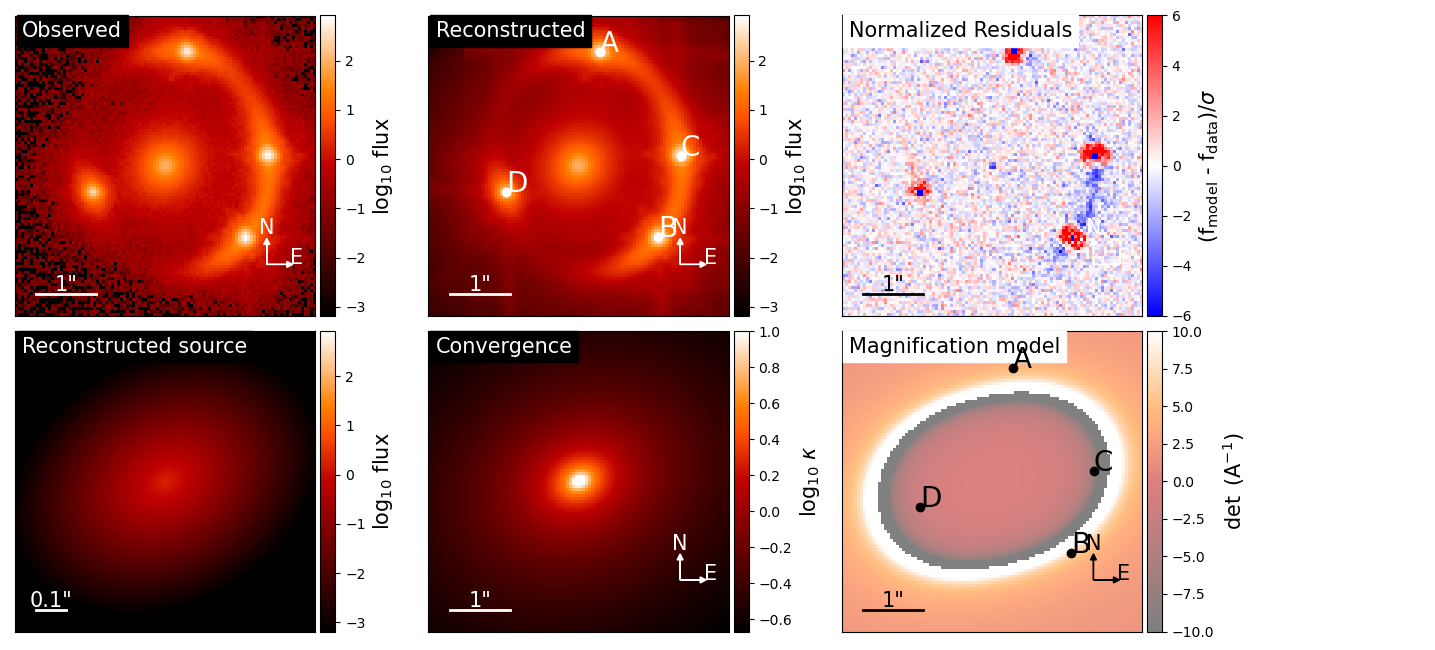

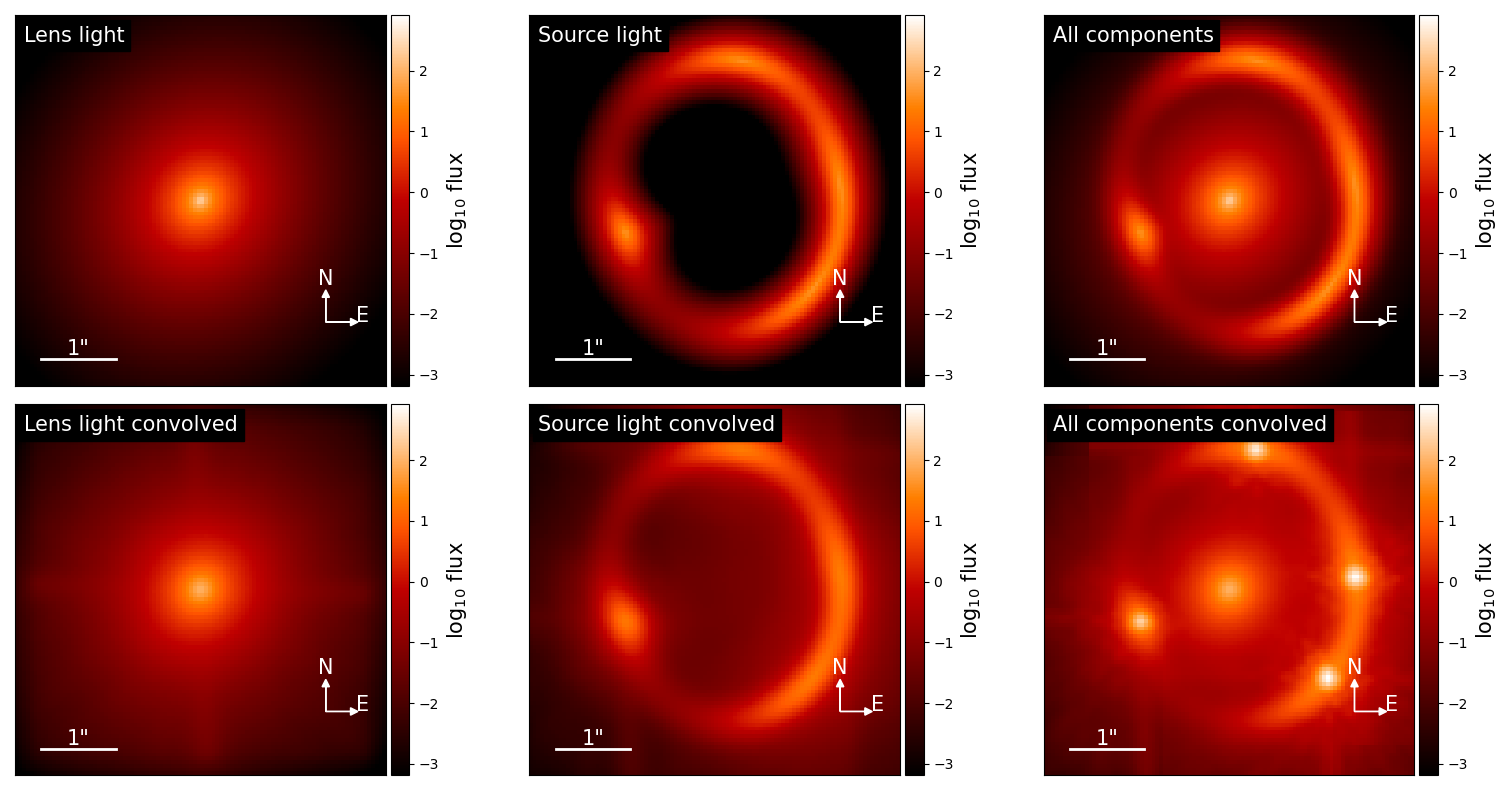

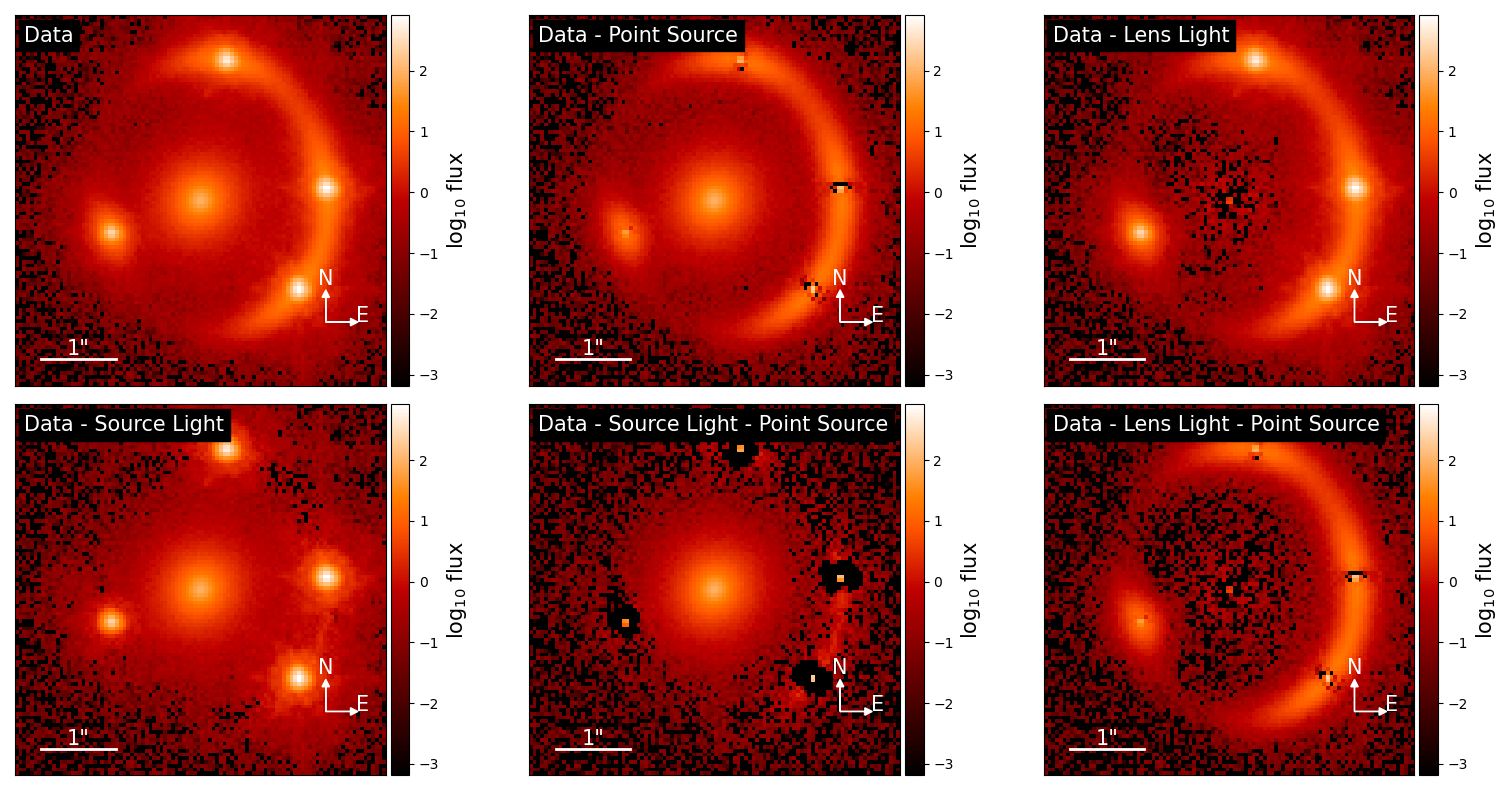

In [6]:
# now we first run a PSO with the wrong PSF
psf_iter_factor = 0.2
psf_iter_num = 100
sigma_scale = 0.1
# numerical options and fitting sequences

num_source_model = len(source_model_list)

kwargs_constraints = {'joint_source_with_point_source': [[0, 0]],
                      'num_point_source_list': [4],
                      'solver_type': 'PROFILE_SHEAR',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                      'Ddt_sampling': True,
                              }

kwargs_likelihood = {'check_bounds': True,
                             'force_no_add_image': False,
                             'source_marg': False,
                             'image_position_uncertainty': 0.004,
                             'check_matched_source_position': True,
                             'source_position_tolerance': 0.001,
                             'time_delay_likelihood': True,
                             }

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear',
                    'time_delays_measured': dt_measured,
                    'time_delays_uncertainties': dt_sigma,}

kwargs_init = [kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps]

from lenstronomy.Workflow.fitting_sequence import FittingSequence

mpi = False  # MPI possible, but not supported through that notebook.

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
fitting_kwargs_list = [['update_settings', {'lens_add_fixed': [[0, ['gamma']]]}],
                       ['PSO', {'sigma_scale': sigma_scale, 'n_particles': 100, 'n_iterations': 100}],]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

# here is the output

from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main(); f.show()
f, axes = modelPlot.plot_separate(); f.show()
f, axes = modelPlot.plot_subtract_from_data_all(); f.show()

iteration of step 100 gave best reconstruction.
log likelihood before: -17666.33167074967 and log likelihood after: -10869.295626918154
-2.173859125383632 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  2.1738591253836326


/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/chain_plot.py:200: RuntimeWarning: divide by zero encountered in log10
  np.log10(psf_error_map * psf.kernel_point_source**2),
/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_81754/3287183386.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_81754/3287183386.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_81754/3287183386.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_81754/3287183386.py:23: UserWarning: Matplotlib is cur

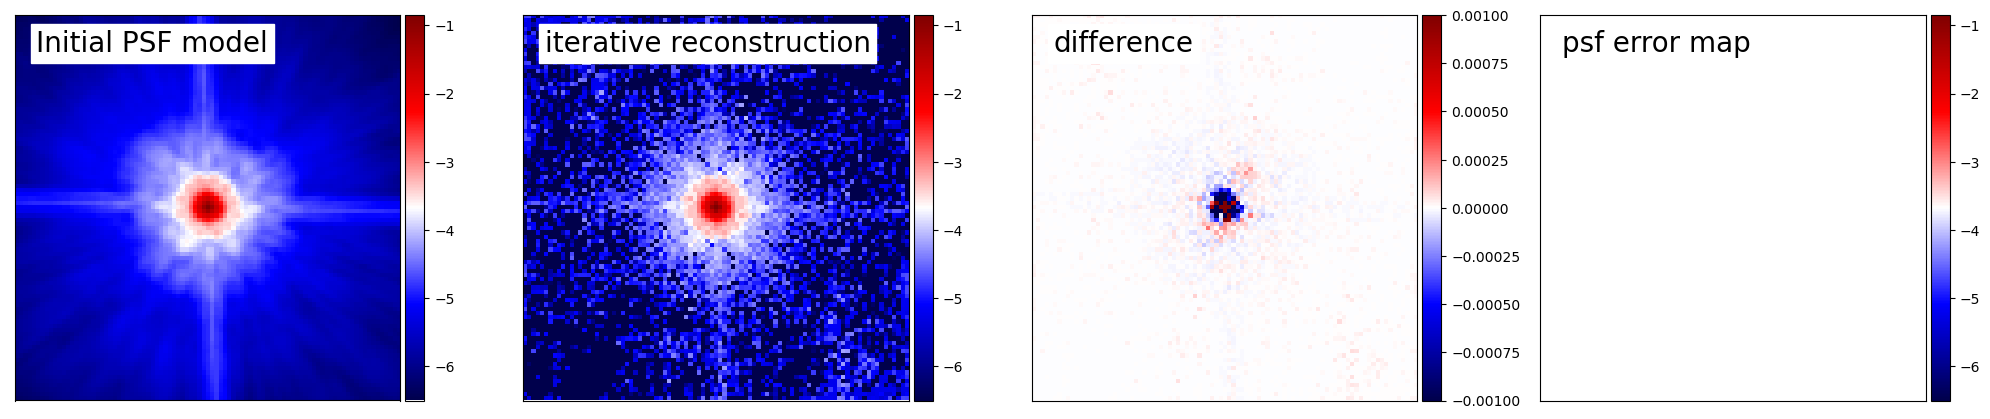

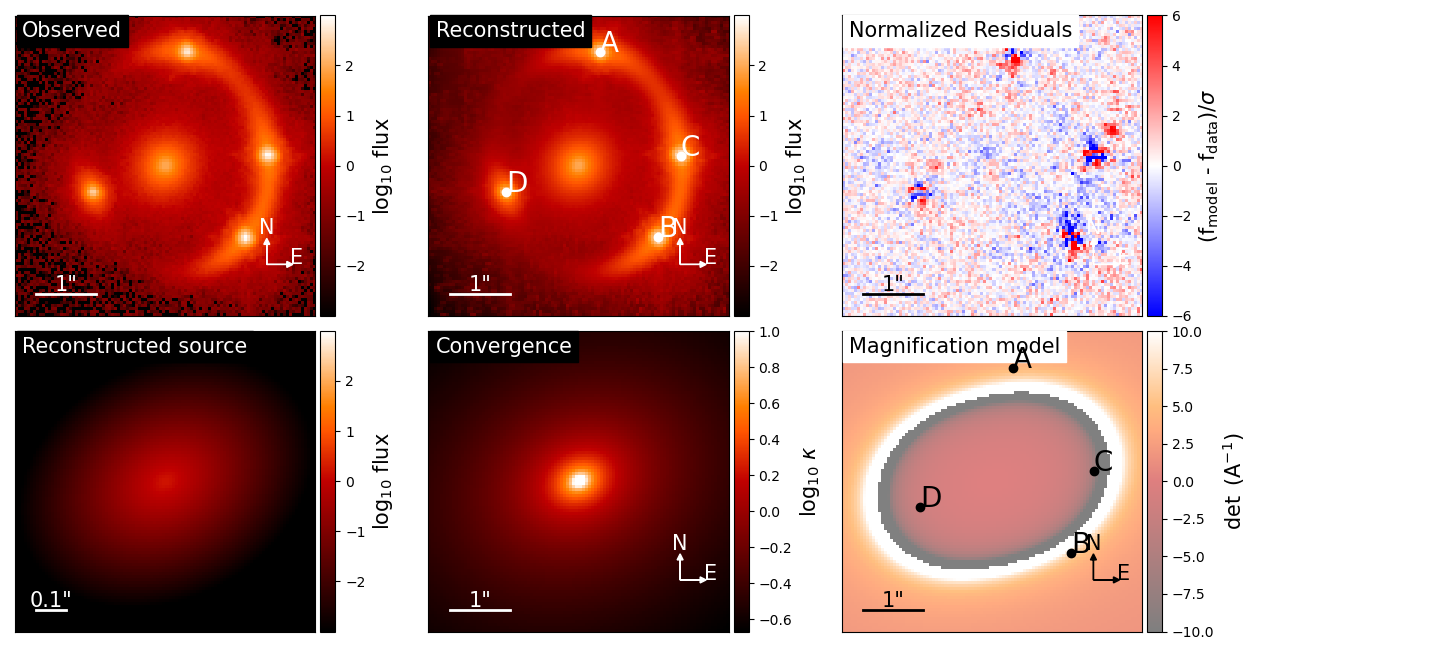

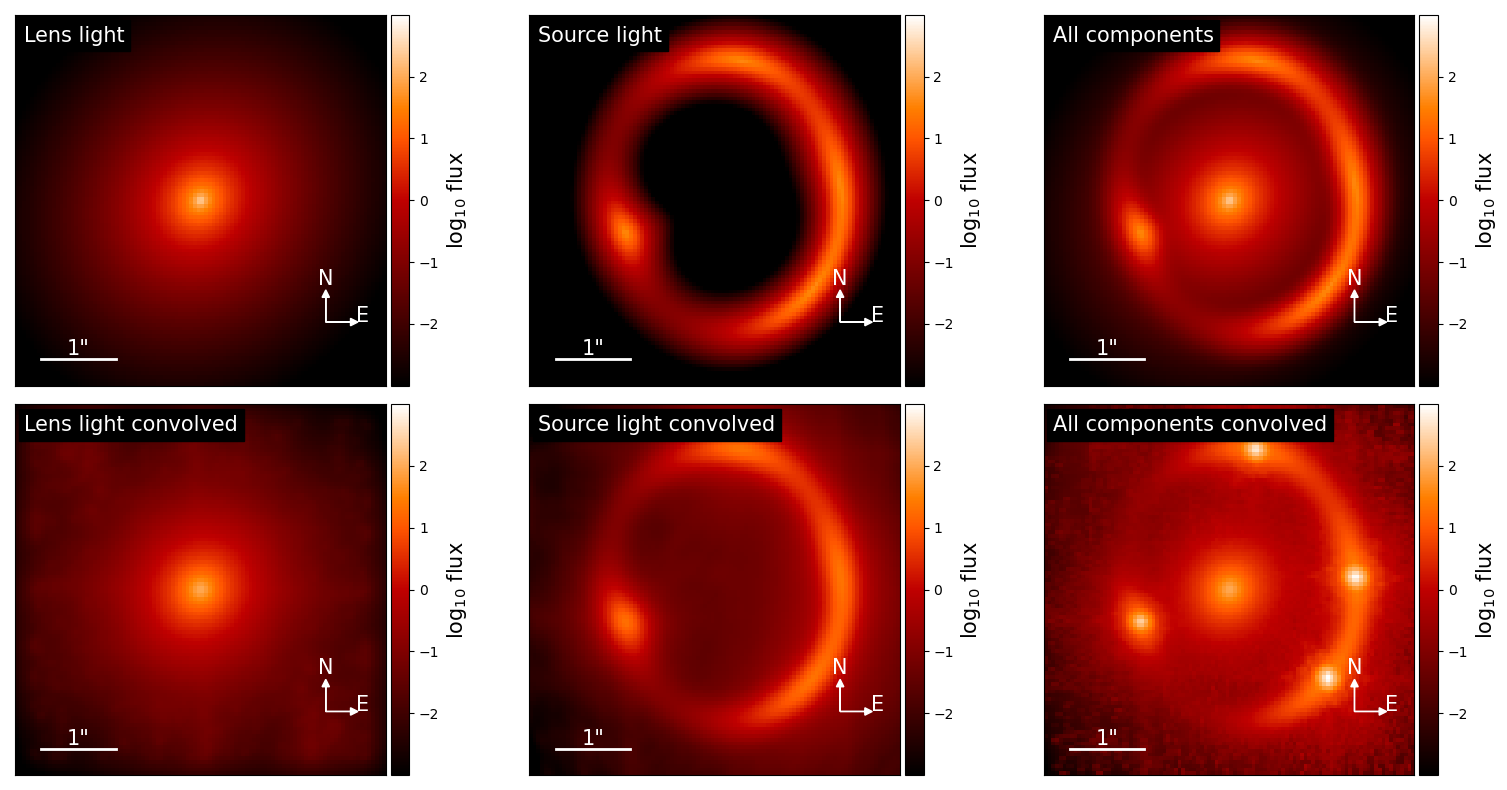

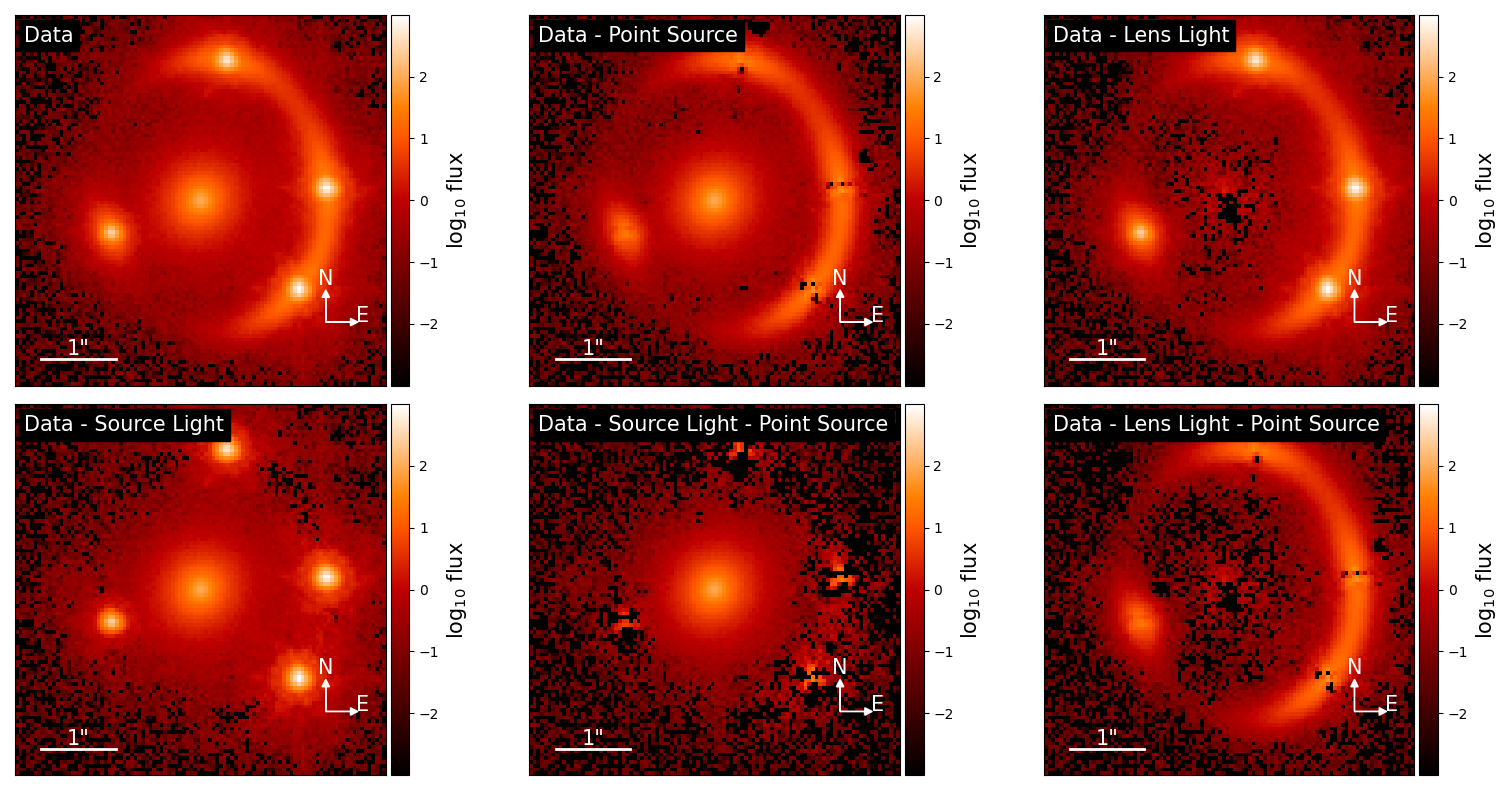

In [7]:
#now we run an iterative PSF reconstruction with the best fit model of the previous run
kwargs_psf_iter = {'stacking_method': 'median', 
                   'keep_psf_error_map': True, 
                   'psf_symmetry': 2, 
                   'block_center_neighbour': 0.05,
                   'num_iter': psf_iter_num, 
                   'psf_iter_factor': psf_iter_factor}

fitting_kwargs_list = [['psf_iteration', kwargs_psf_iter]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
#lens_result, source_result, lens_light_result, ps_result, cosmo_result

multi_band_list = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]
f, axes = chain_plot.psf_iteration_compare(kwargs_psf_updated)
f.show()
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f.show()
f, axes = modelPlot.plot_separate()
f.show()
f, axes = modelPlot.plot_subtract_from_data_all()
f.show()



Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-2.0845157531761678 reduced X^2 of best position
-10396.522318966137 log likelihood
9975 effective number of data points
[{'theta_E': 1.6545645030782188, 'gamma': 2.004546581677988, 'e1': 0.0852557914022247, 'e2': 0.09265176699036748, 'center_x': 0.01198059186745153, 'center_y': 0.006881895208424558}, {'gamma1': -0.06301309876159172, 'gamma2': -0.007921341742208128, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.10217189052487609, 'n_sersic': 0.9661708944612156, 'e1': 0.06965770061431638, 'e2': 0.10637830762570989, 'center_x': 0.21452669088450443, 'center_y': 0.10688491860539895}] source result
[{'amp': 1, 'R_sersic': 0.19909330889311785, 'n_sersic': 2.0460057872875343, 'e1': -0.0088414048023976, 'e2': 0.05174992618714019, 'center_x': 0.00013198407404118044, 'center_y': 0.001467966380611043}] lens light result
[{'ra_image': array([ 0.35294688,  1.32500173,  1.69952731, -1.19787137]), 'd

/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_81754/2406359910.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_81754/2406359910.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_81754/2406359910.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_81754/2406359910.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


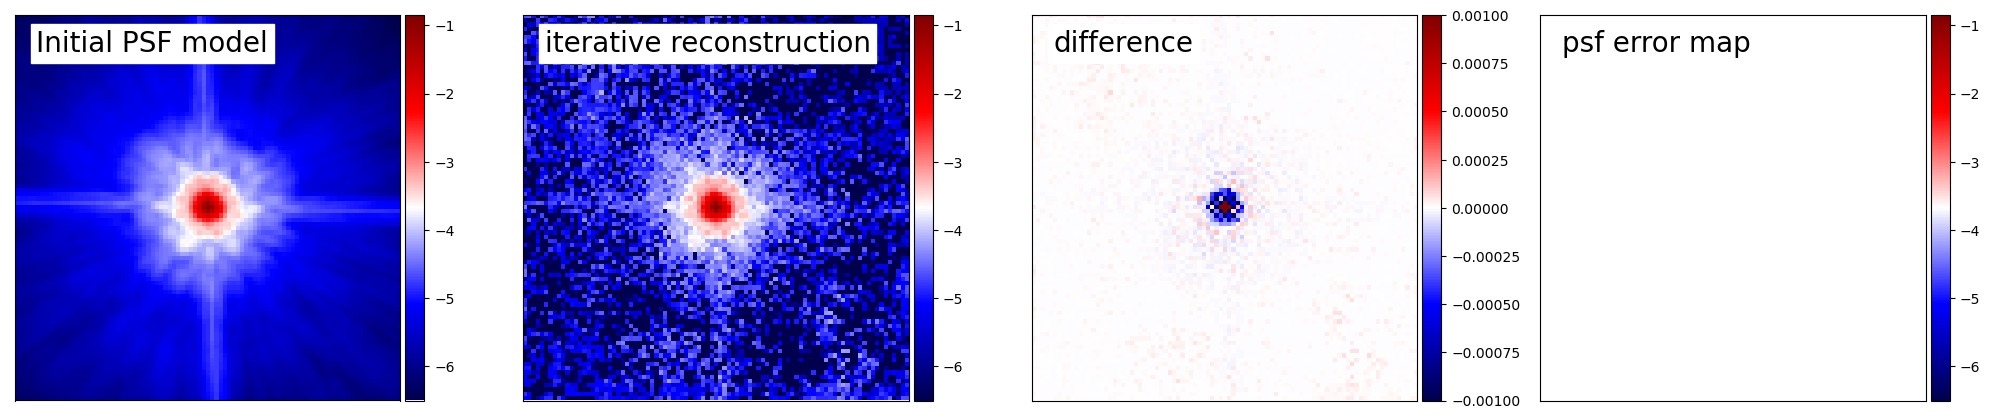

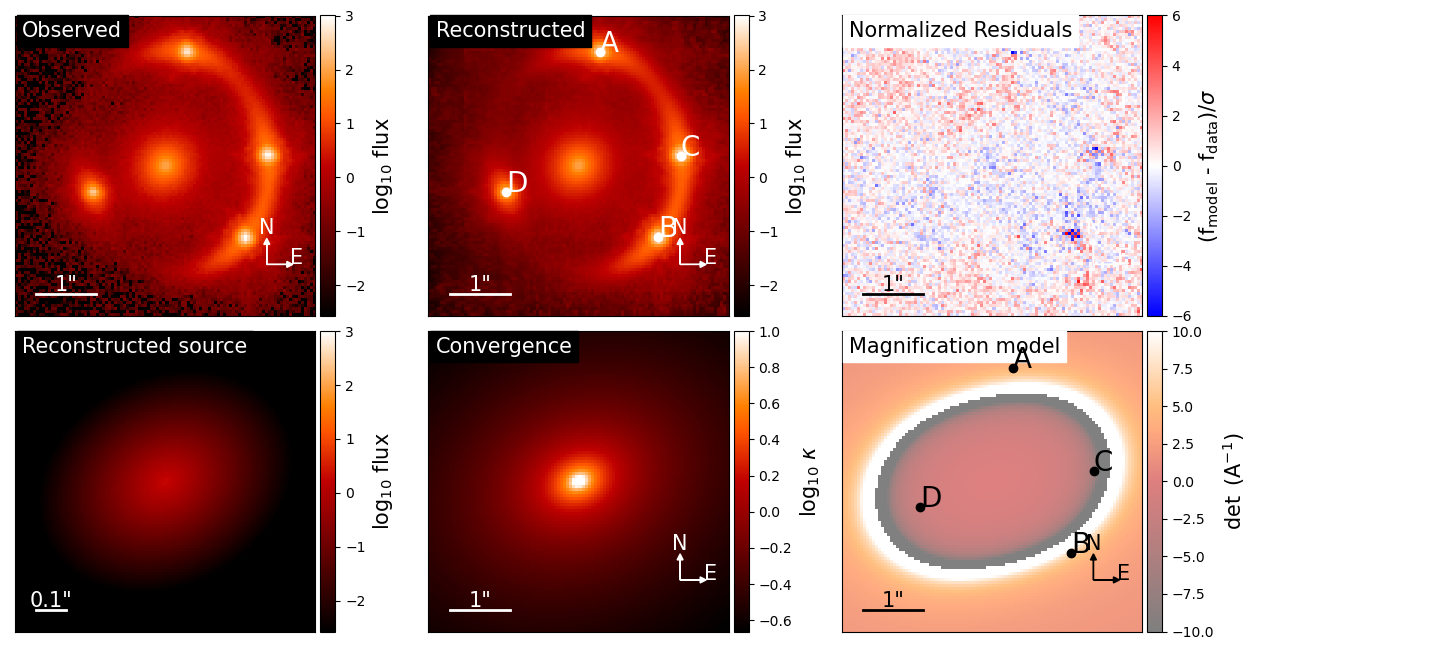

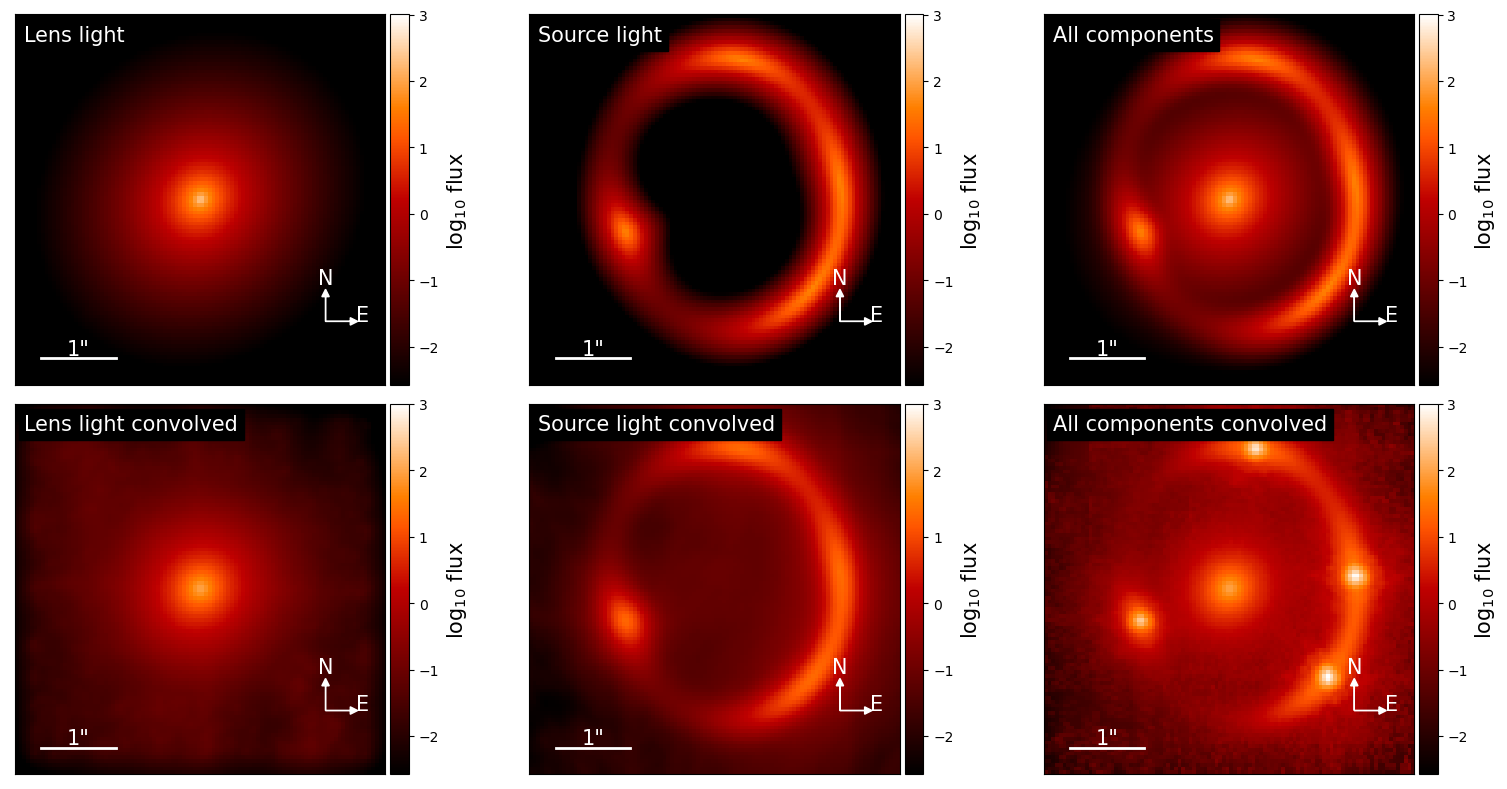

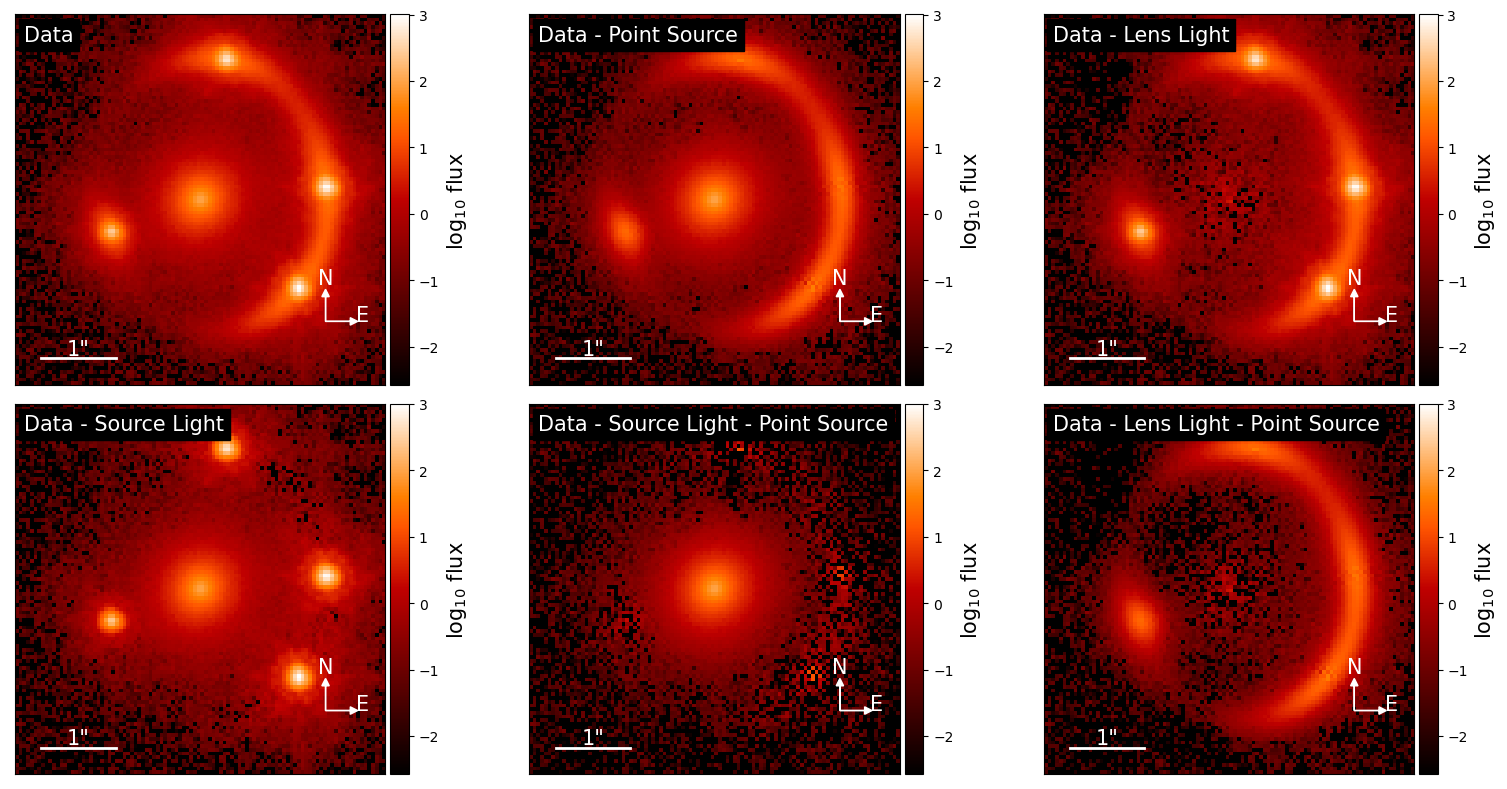

In [8]:
kwargs_psf_iter = {'stacking_method': 'median', 
                   'keep_psf_error_map': True, 
                   'psf_symmetry': 1, 
                   'block_center_neighbour': 0.05,
                   'num_iter': psf_iter_num, 
                   'psf_iter_factor': psf_iter_factor}

# and now we run another PSO optimization followed by another PSF iteration
fitting_kwargs_list = [['update_settings', {'lens_remove_fixed': [[0, ['gamma']]]}],
    ['PSO', {'sigma_scale': sigma_scale, 'n_particles': 100, 'n_iterations': 100}],
    ['psf_iteration', kwargs_psf_iter],
    ['PSO', {'sigma_scale': sigma_scale, 'n_particles': 100, 'n_iterations': 100}],
    ['psf_iteration', kwargs_psf_iter]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

multi_band_list = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]
f, axes = chain_plot.psf_iteration_compare(kwargs_psf_updated)
f.show()
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f.show()
f, axes = modelPlot.plot_separate()
f.show()
f, axes = modelPlot.plot_subtract_from_data_all()
f.show()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.9835956090018433 reduced X^2 of best position
-4905.683099896693 log likelihood
9975 effective number of data points
[{'theta_E': 1.657335404041359, 'gamma': 1.9570153825637895, 'e1': 0.0888755034953342, 'e2': 0.0939147224415308, 'center_x': 0.006463482702402038, 'center_y': 0.0044372012980421855}, {'gamma1': -0.055123574930207, 'gamma2': -0.0029922960121393214, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.09698362268469804, 'n_sersic': 0.9399828942017849, 'e1': 0.06651036059542095, 'e2': 0.09721765958332255, 'center_x': 0.20272527968731616, 'center_y': 0.10166896264573273}] source result
[{'amp': 1, 'R_sersic': 0.19339165300624167, 'n_sersic': 1.9168021602635834, 'e1': -0.009142842797398524, 'e2': 0.05401744066214332, 'center_x': 0.00035653229072075444, 'center_y': 0.0006106959130575864}] lens light result
[{'ra_image': array([ 0.35293982,  1.32500931,  1.69960336, -1.19787633]), 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:48<00:00,  2.28s/it]
/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_81754/4013513248.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


Computing the MCMC...
Number of walkers =  220
Burn-in iterations:  50
Sampling iterations (in current run): 100
230.56405806541443 time taken for MCMC sampling
-0.9818305578282379 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9818305578282384


/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_81754/4013513248.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_81754/4013513248.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_81754/4013513248.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


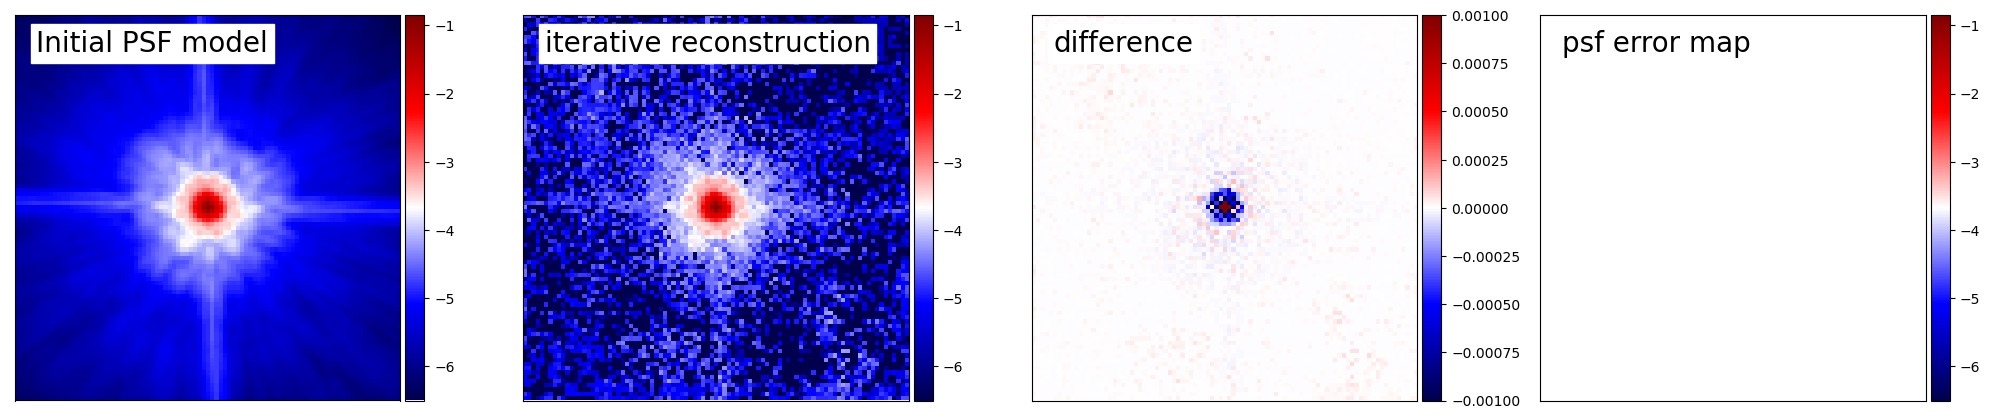

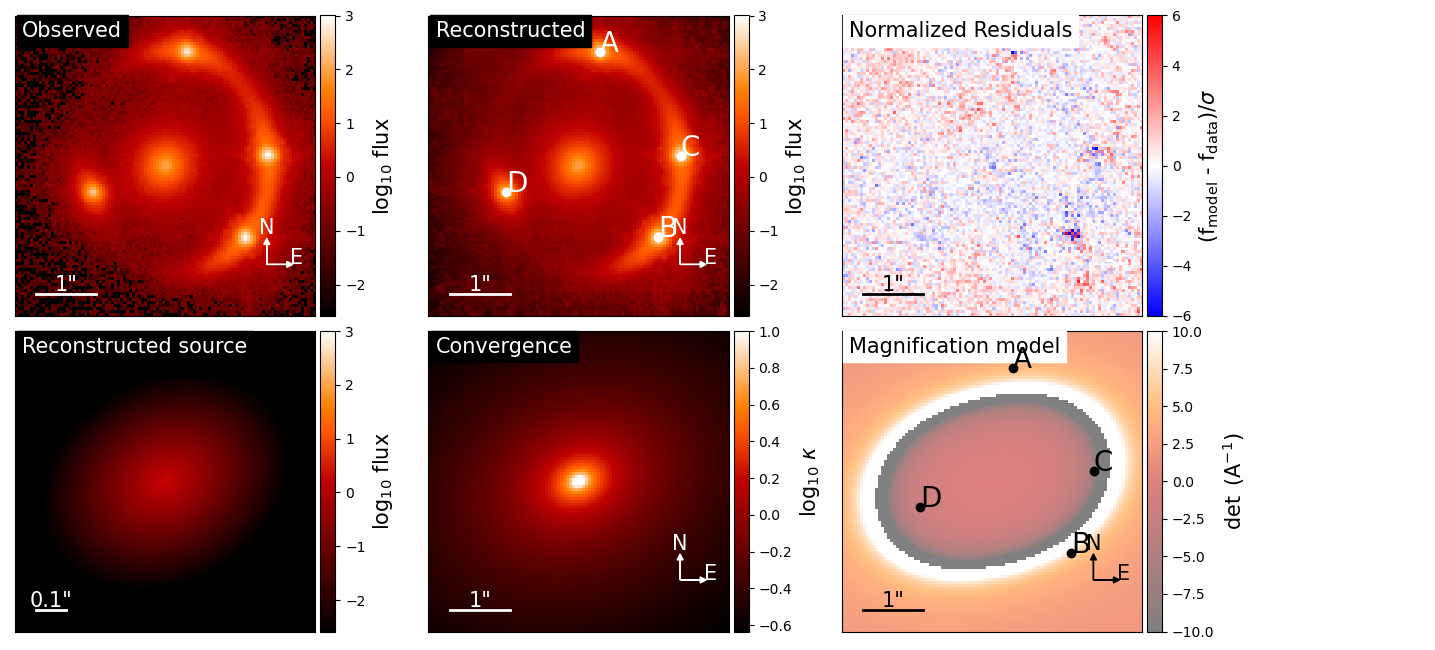

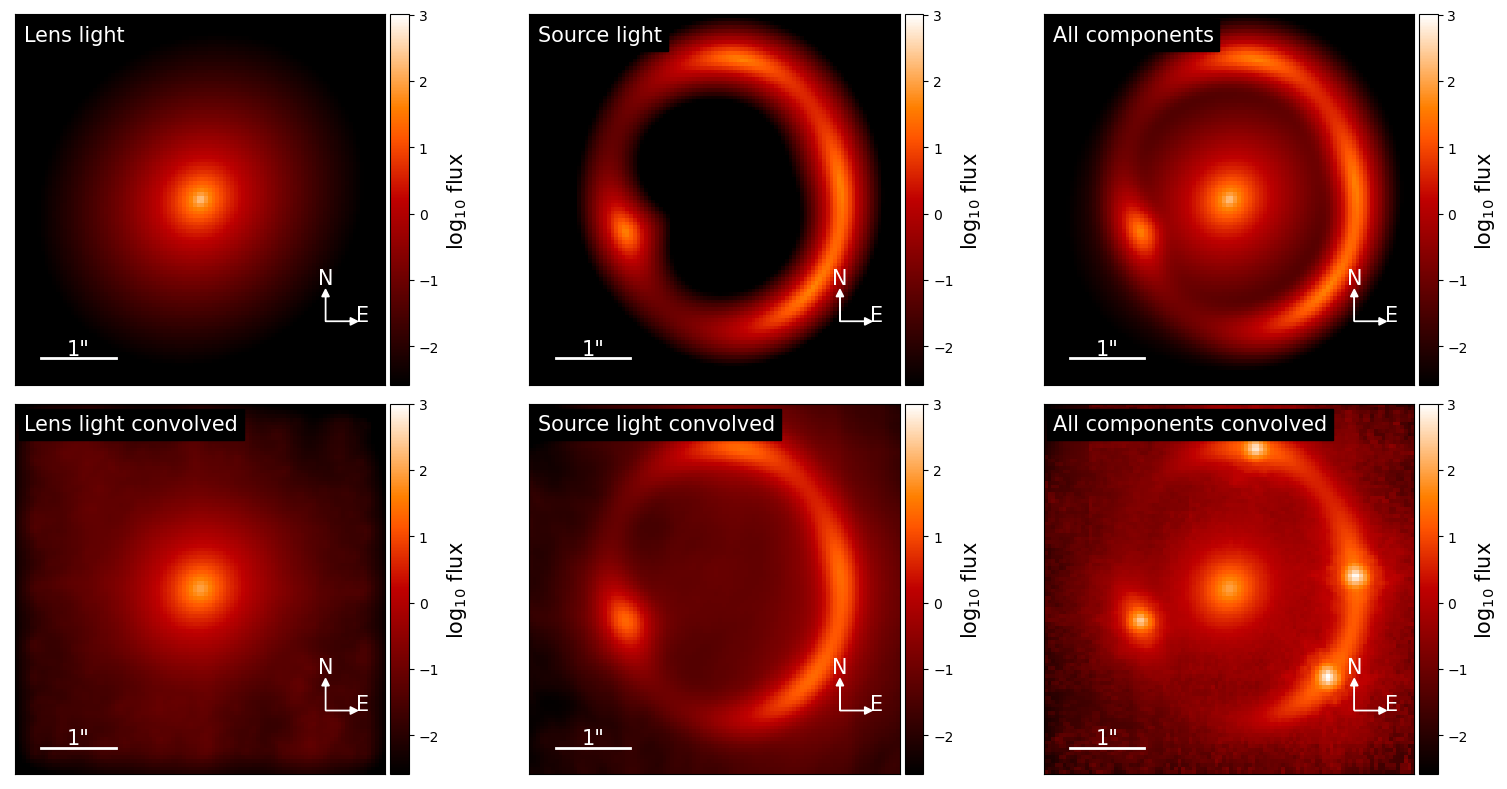

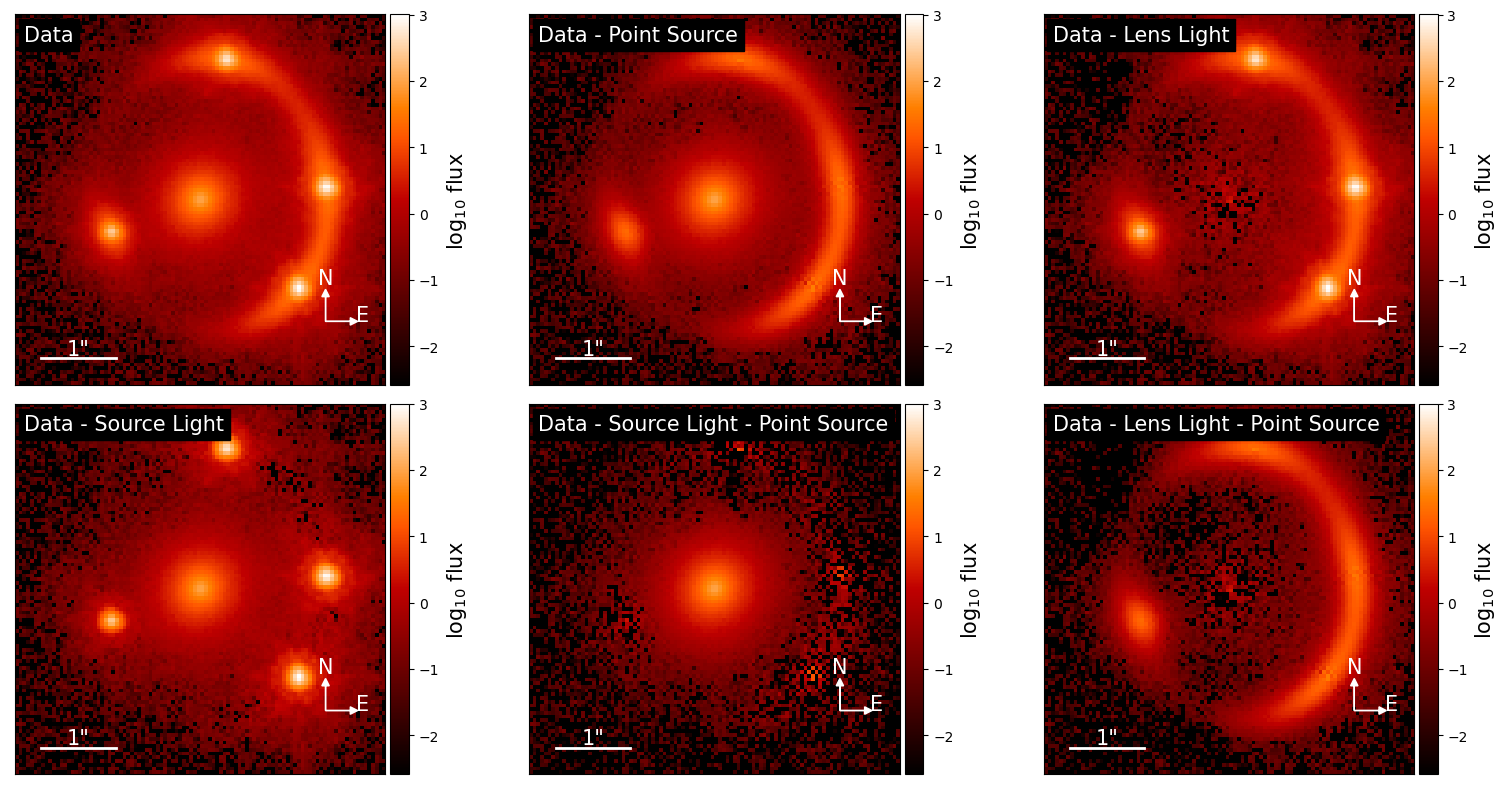

In [9]:
#and now we run the MCMC
fitting_kwargs_list = [
    ['PSO', {'sigma_scale': .1, 'n_particles': 100, 'n_iterations': 100}],
    ['MCMC', {'n_burn': 50, 'n_run': 50, 'walkerRatio': 10,'sigma_scale': .1}]
]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

multi_band_list = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]
f, axes = chain_plot.psf_iteration_compare(kwargs_psf_updated)
f.show()
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f.show()
f, axes = modelPlot.plot_separate()
f.show()
f, axes = modelPlot.plot_subtract_from_data_all()
f.show()

number of non-linear parameters in the MCMC process:  22
parameters in order:  ['gamma_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image', 'D_dt']
number of evaluations in the MCMC process:  11000
3329.6653609254795


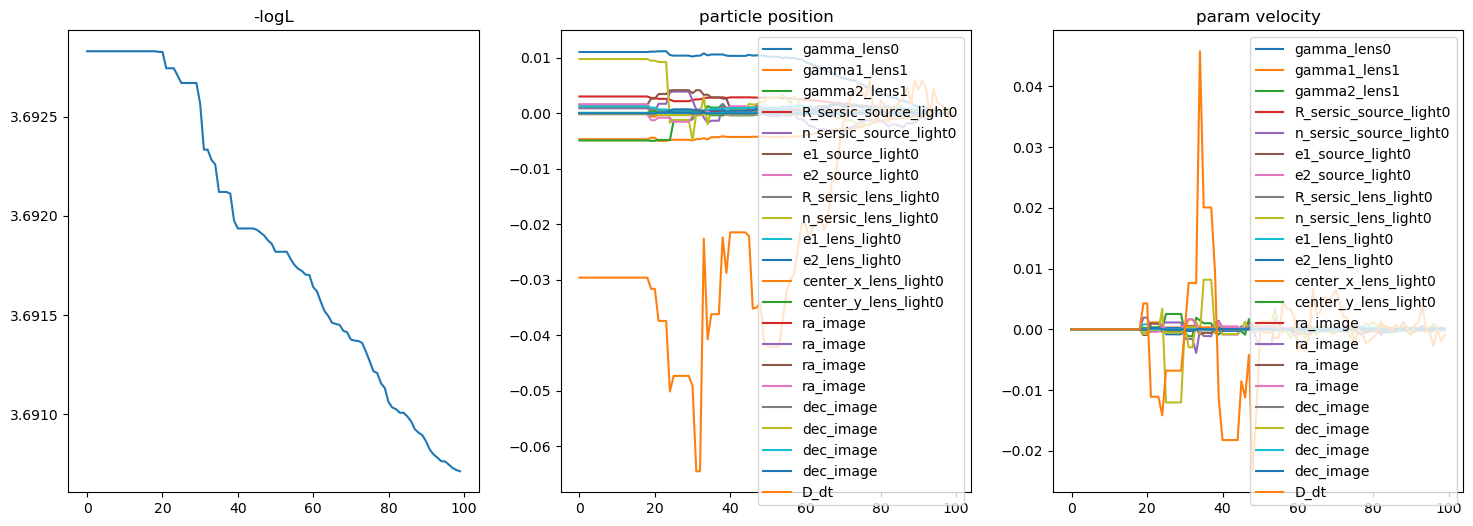

<Figure size 640x480 with 0 Axes>

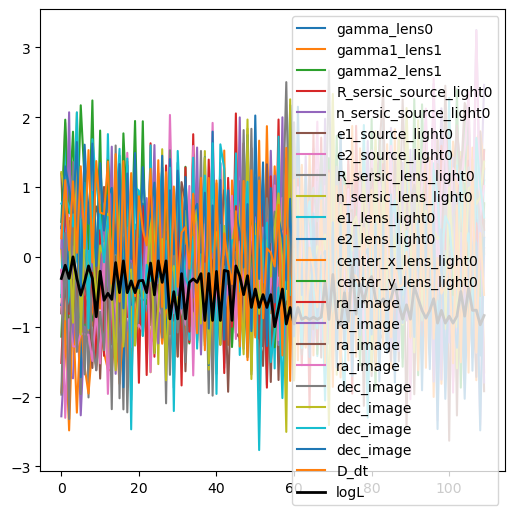

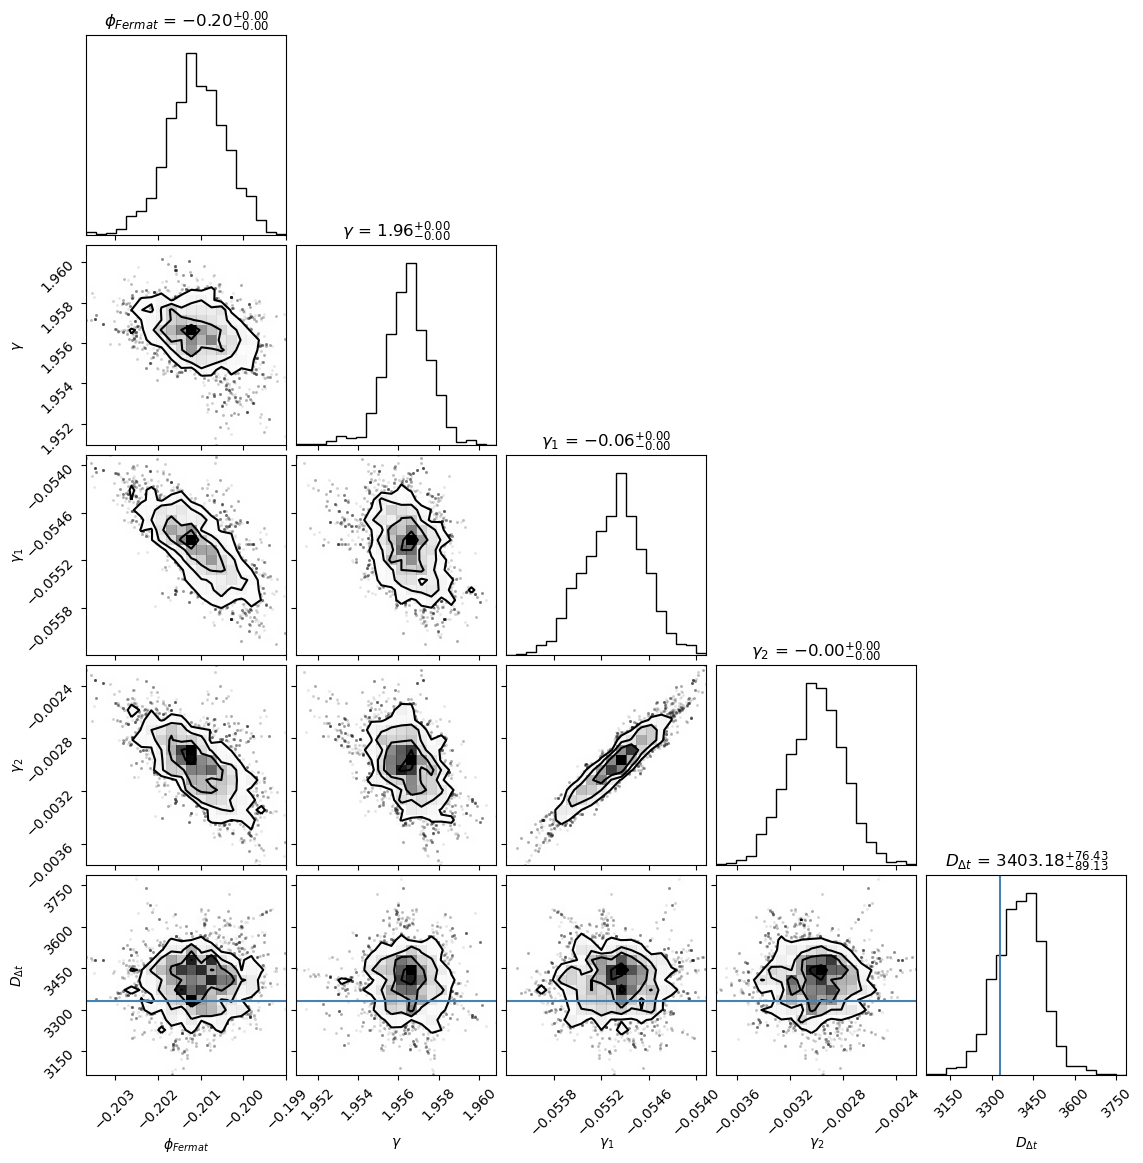

In [11]:
for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
import corner


# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model, fixed_lens, fixed_source, fixed_lens_light, fixed_ps, fixed_cosmo, 
              kwargs_lens_init=kwargs_result['kwargs_lens'], **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()

from lenstronomy.Analysis.td_cosmography import TDCosmography
td_cosmo = TDCosmography(z_lens, z_source, kwargs_model, cosmo_fiducial=cosmo)

mcmc_new_list = []
labels_new = [r"$\phi_{Fermat}$", r"$\gamma$", r"$\gamma_1$", r"$\gamma_2$", r"$D_{\Delta t}$"]
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_result = param.args2kwargs(samples_mcmc[i])
    D_dt = kwargs_result['kwargs_special']['D_dt']
    fermat_pot = td_cosmo.fermat_potential(kwargs_result['kwargs_lens'], kwargs_result['kwargs_ps'])
    delta_fermat_12 = fermat_pot[0] - fermat_pot[2]
    gamma = kwargs_result['kwargs_lens'][0]['gamma']
    gamma1, gamma2, = kwargs_result['kwargs_lens'][1]['gamma1'], kwargs_result['kwargs_lens'][1]['gamma2']
    mcmc_new_list.append([delta_fermat_12, gamma, gamma1, gamma2, D_dt])

from lenstronomy.Cosmo.lens_cosmo import LensCosmo
lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)
print(lensCosmo.ddt)
fermat_pot = td_cosmo.fermat_potential(kwargs_lens, kwargs_ps)
delta_fermat_12_true = fermat_pot[0] - fermat_pot[2]

truths=[delta_fermat_12_true, kwargs_lens[0]["gamma"], kwargs_lens[1]["gamma1"], kwargs_lens[1]["gamma2"], lensCosmo.ddt]

plot = corner.corner(np.array(mcmc_new_list), labels=labels_new, show_titles=True, truths=truths)